In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from matplotlib import collections  as mc
from matplotlib.patches import Ellipse
import math
import random
from matplotlib import cm

In [2]:
d = pd.read_csv('Chr20FuncIntx.tsv', sep='\t', header=0)

In [3]:
vertices = set(list(d['a']) + list(d['b']))
edges = [(r['a'], r['b']) for i, r in d.iterrows()]
weights = [r['score'] for i, r in d.iterrows()]

In [4]:
g = nx.Graph()
g.add_nodes_from(list(vertices))
g.add_edges_from(edges)

In [5]:
# TODO find a good community detection fcn
# TODO add edge weights?
communities_generator = community.girvan_newman(g)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
communities = sorted(map(sorted, next_level_communities))

In [6]:
layout = nx.spring_layout(g)

In [7]:
p = [None]*len(layout)
x = [None]*len(layout)
y = [None]*len(layout)

i = 0
for k, v in layout.items():
    p[i] = k
    x[i] = v[0]
    y[i] = v[1]
    i += 1
    
# TODO how to pick color palette?!
colors=[v for k, v in mcolors.CSS4_COLORS.items()]
colors=[colors[i*5] for i in range(len(communities))]

In [8]:
xy_centers = np.ones((len(communities), 2))

for j, community in zip(range(len(communities)), communities):
    nproteins=len(community)
    p_x = [None]*nproteins
    p_y = [None]*nproteins
    
    for i, protein in zip(range(nproteins), community):
        p_x[i] = layout[protein][0]
        p_y[i] = layout[protein][1]
        
    p_x = np.array(p_x)
    p_y = np.array(p_y)
    
    x_rad = (np.max(p_x) - np.min(p_x))/2.0
    y_rad = (np.max(p_y) - np.min(p_y))/2.0
    xy_centers[j] = [x_rad+np.min(p_x), y_rad+np.min(p_y)]
    
xy_centers = xy_centers*100

In [9]:
#fig = plt.figure(figsize=(10, 10))
#nx.draw(g, pos=layout)
#plt.show()

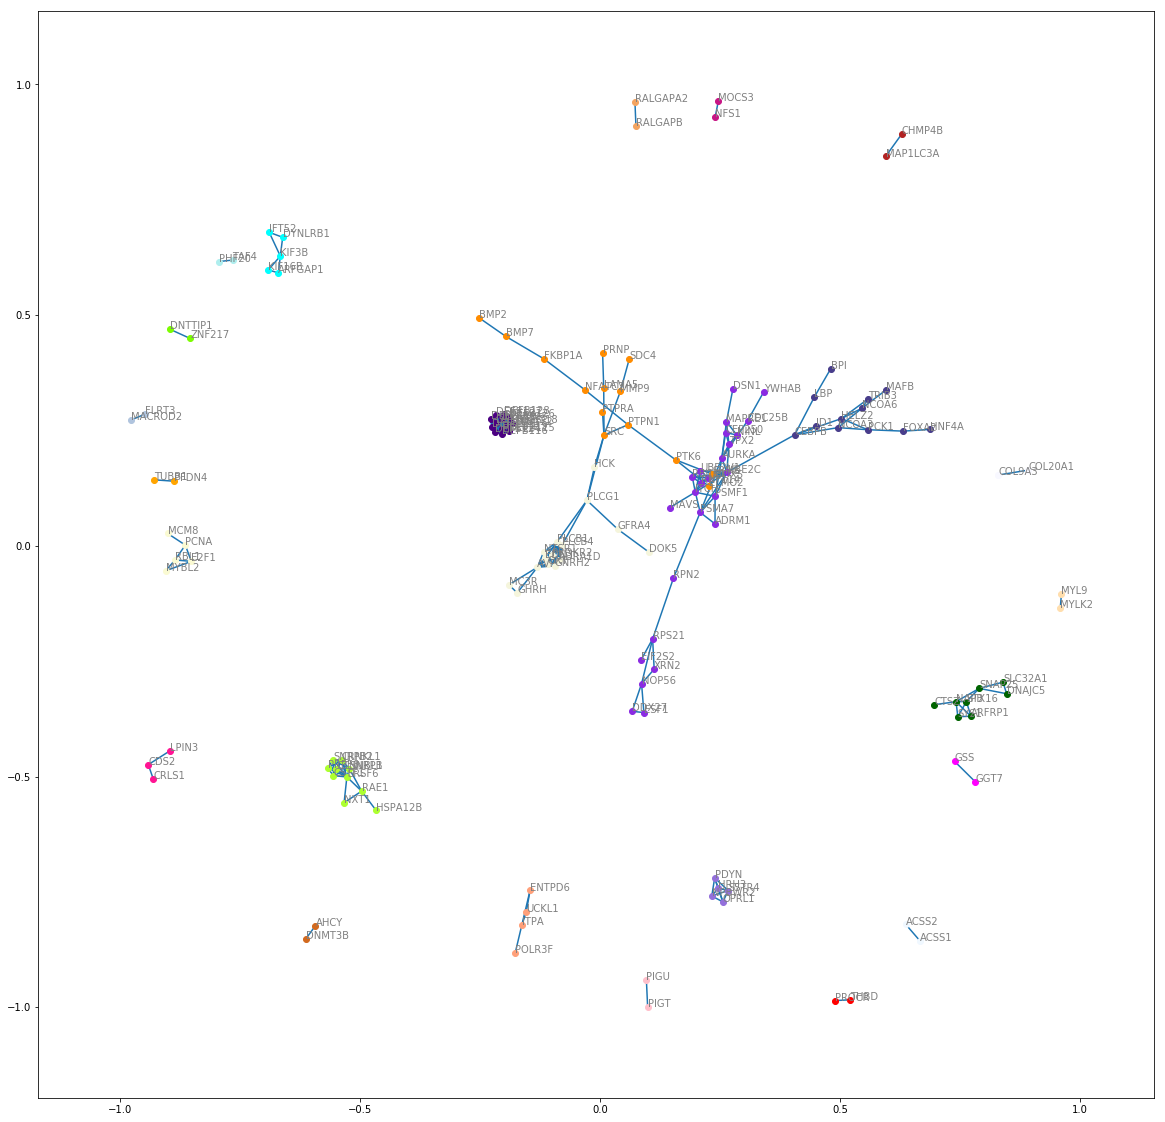

In [10]:
lines = [None]*len(edges)
for i, e in zip(range(len(edges)), edges):
    pos0 = layout[e[0]]
    pos1 = layout[e[1]]
    lines[i] = [(pos0[0], pos0[1]), (pos1[0], pos1[1])]
lc = mc.LineCollection(lines)

fig, ax = plt.subplots(figsize=[20,20])
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

for community, color in zip(communities, colors):
    for protein in community:
        pos = layout[protein]
        plt.plot(pos[0], pos[1], color=color, marker='o')
        
for i in range(len(p)):
    plt.text(x[i], y[i], p[i], color='gray')
        
plt.show()

In [11]:
#plt.figure(figsize=[20, 20])

#for i in range(len(p)):
    #plt.text(x[i], y[i], p[i], color='gray')

#for community, color in zip(communities, colors):
#    for protein in community:
#        pos = layout[protein]
        #plt.plot(pos[0], pos[1], color=color, marker='o')  

#plt.show()

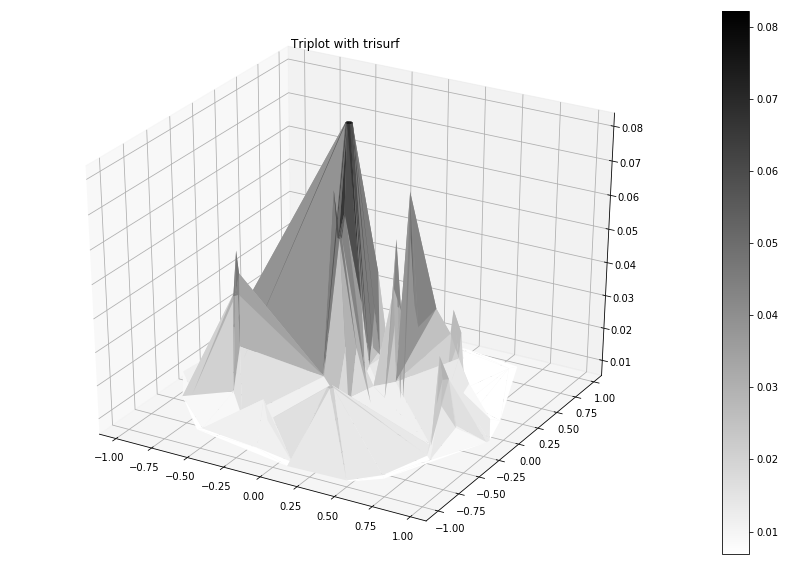

In [12]:
triang = mtri.Triangulation(x, y)

cen = nx.degree_centrality(g)
z = [None] * len(x)
for i in range(len(x)):
    z[i] = cen[p[i]]

fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(triang, z, linewidth=0.1, antialiased=True, cmap='gray_r', shade=True)
fig.colorbar(surf)
plt.title('Triplot with trisurf')
plt.show()

In [13]:
# https://stackoverflow.com/questions/39402109/generating-points-on-a-circle
def points_along_ellipse(x_radius, y_radius, x_center, y_center, inner_shift=0):
    x = []
    y = []
    if inner_shift >= min(x_radius, y_radius):
        print('ERROR: points_along_ellipse - inner_shift')
        return None
    for i in range(0,1000):
        angle = random.uniform(0,1)*(math.pi*2)
        x.append(x_center + (x_radius-inner_shift)*math.cos(angle));
        y.append(y_center + (y_radius-inner_shift)*math.sin(angle));
    return {'x': x, 'y': y}

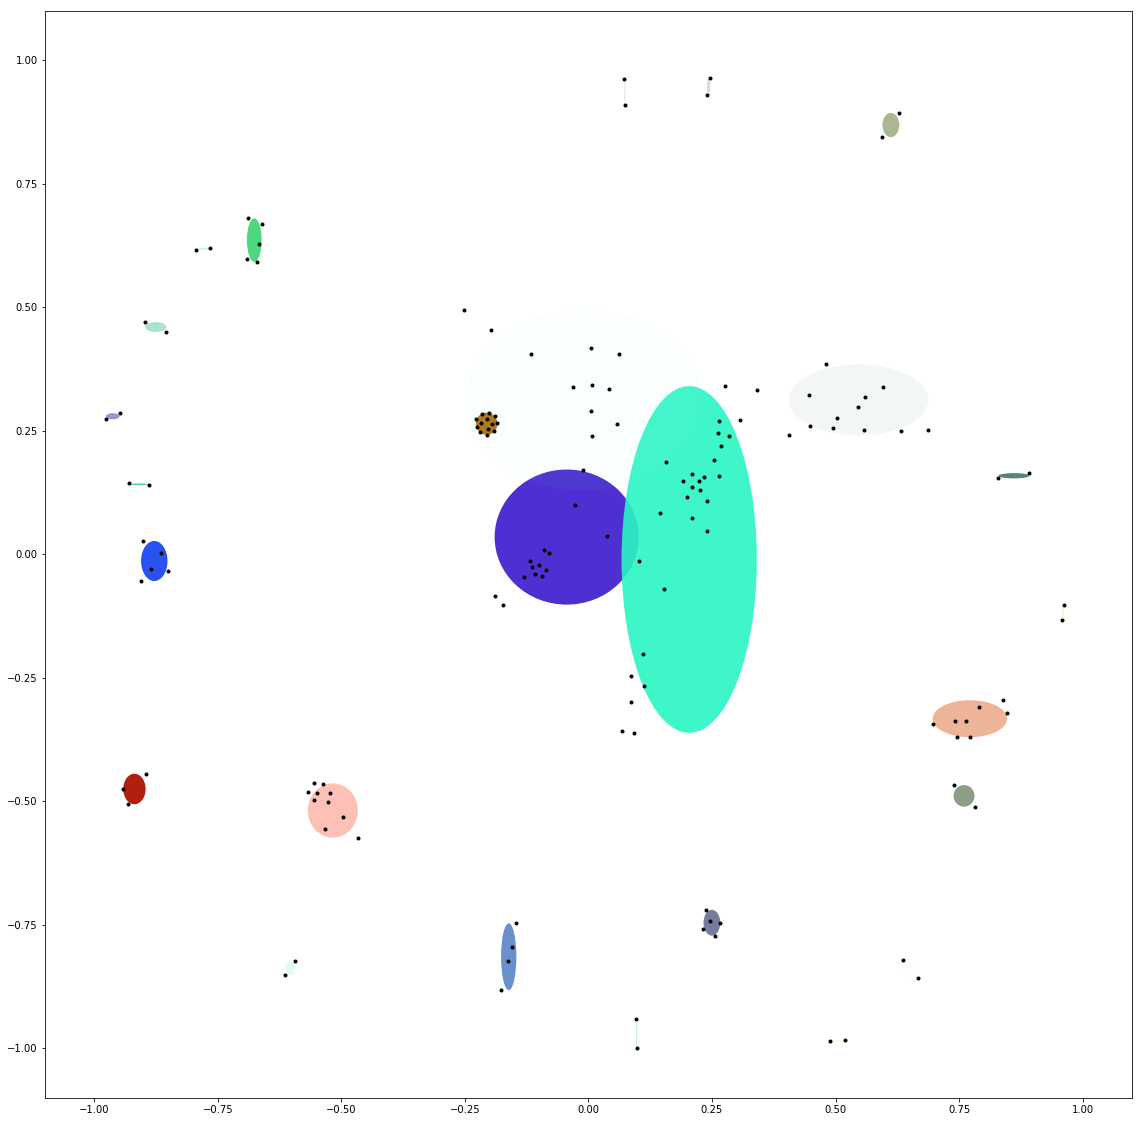

In [14]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=[20,20])

for community in communities:
    
    p_x = [None]*len(community)
    p_y = [None]*len(community)
    p_z = [None]*len(community)
    
    for i, protein in zip(range(len(community)), community):
        p_x[i] = layout[protein][0]
        p_y[i] = layout[protein][1]
        p_z[i] = cen[protein]
        pos = layout[protein]
        ax.plot(p_x[i], p_y[i], marker='.', color='k')
        
    p_x = np.array(p_x)
    p_y = np.array(p_y)
    p_z = np.array(p_z)
    
    x_rad = (np.max(p_x) - np.min(p_x))/2.0
    y_rad = (np.max(p_y) - np.min(p_y))/2.0
    center = [x_rad+np.min(p_x), y_rad+np.min(p_y)]
    
    e = Ellipse(xy=center, width=x_rad*2, height=y_rad*2, angle=180)
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(np.random.rand())
    e.set_facecolor(np.random.rand(3))
    
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

plt.show()
                          

In [15]:
# https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

def multivariate_gaussian_XYZ(N, center, xy_score, z_score):
    X = np.linspace(-3, 3, N)
    Y = np.linspace(-3, 4, N)
    X, Y = np.meshgrid(X, Y)

    # Mean vector and covariance matrix
    mu = np.array([0., 1.])
    Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])
    
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)
    
    # scale to be in [-xy_score, xy_score]
    X = X * xy_score + center[0]
    Y = Y * xy_score + center[1]
    Z *= z_score
    
    return X, Y, Z

In [16]:
X, Y, Z = multivariate_gaussian_XYZ(N=60,
                                    center=(1,4),
                                    xy_score=1,
                                    z_score=2)


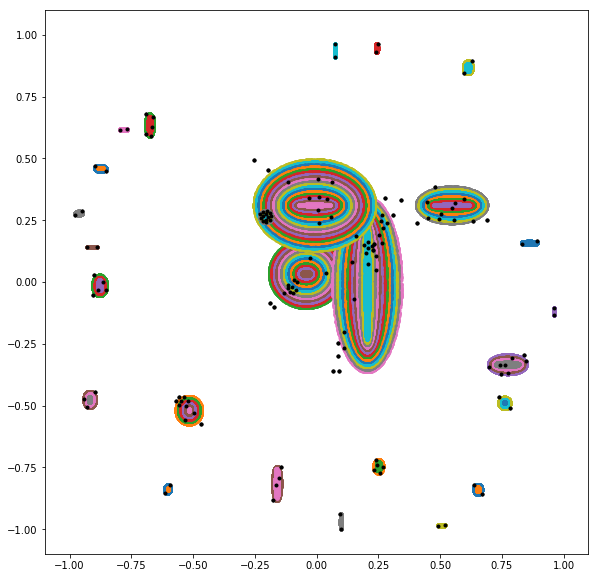

In [17]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=[10,10])

for community in communities:
    
    p_x = [None]*len(community)
    p_y = [None]*len(community)
    p_z = [None]*len(community)
    
    for i, protein in zip(range(len(community)), community):
        p_x[i] = layout[protein][0]
        p_y[i] = layout[protein][1]
        p_z[i] = cen[protein]
        pos = layout[protein]
        ax.plot(p_x[i], p_y[i], marker='.', color='k')
        
    p_x = np.array(p_x)
    p_y = np.array(p_y)
    p_z = np.array(p_z)
    
    x_rad = (np.max(p_x) - np.min(p_x))/2.0
    y_rad = (np.max(p_y) - np.min(p_y))/2.0
    center = [x_rad+np.min(p_x), y_rad+np.min(p_y)]
    
    for i in np.arange(0, max(0, min(x_rad, y_rad)), 0.01):
        ellipse = points_along_ellipse(x_radius=x_rad,
                                       y_radius=y_rad,
                                       x_center=center[0],
                                       y_center=center[1],
                                       inner_shift = i)
        ax.plot(ellipse['x'], ellipse['y'], '.')
        
    for i, protein in zip(range(len(community)), community):
        pos = layout[protein]
        ax.plot(p_x[i], p_y[i], marker='.', color='k')
    
    #e = Ellipse(xy=center, width=x_diam, height=y_diam, angle=180)
    #ax.add_artist(e)
    #e.set_clip_box(ax.bbox)
    #e.set_alpha(np.random.rand())
    #e.set_facecolor(np.random.rand(3))
    
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

plt.show()
                          

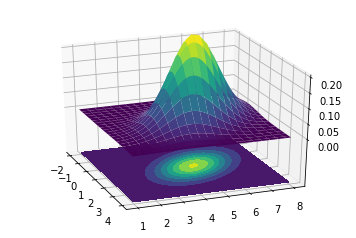

In [18]:
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

In [19]:
z0 = []
for i in range(len(communities)):
    community = communities[i]
    center = xy_centers[i]
    
    nproteins = len(community)
    ngo = nproteins #TODO
    
    X,Y,Z = multivariate_gaussian_XYZ(N=60,
                                      center=center,
                                      xy_score=math.log(nproteins),
                                      z_score=math.log(nproteins)/5)
    z0.append(np.max(Z))

In [20]:
gene_data = pd.read_csv('Chr20GeneData.tsv', sep='\t', header=0)

In [21]:
increment= 360.0/131
degrees=[]
for i in range(1,132):
    degree=i*increment
    degrees.append(degree)
x_=[]
y_=[]

for i in degrees:
    x=100*math.cos(math.radians(i))
    y=100*math.sin(math.radians(i))
    x_.append(x)
    y_.append(y)
x=np.asarray(x_)
y=np.asarray(y_)
z=np.empty(131)
z.fill(0.5)

#ax.scatter(x, y, z)
    
GO_P=gene_data[['GO_P']]
GO_P=GO_P.dropna()
GO_P=GO_P.GO_P.unique()
GO_P=list(GO_P)

GO_C=gene_data[['GO_C']]
GO_C=GO_C.dropna()
GO_C=GO_C.GO_C.unique()
GO_C=list(GO_C)

GO_F=gene_data[['GO_F']]
GO_F=GO_F.dropna()
GO_F=GO_F.GO_F.unique()
GO_F=list(GO_F)

#x_y=zip(x_,y_)
x_y=[(x_0, y_0) for x_0, y_0 in zip(x_, y_)]
circle_tuples=[]
go_dict = {}

j = 0
for i in range(0, len(GO_P)):
    GO=GO_P[j]
    j += 1
    color='r'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    #ax.scatter(x_y[i][0], x_y[i][1], 0.5, c=color)
    go_dict[GO]=coordinates

j = 0
for i in range(len(GO_P), len(GO_P)+len(GO_C)):
    GO=GO_C[j]
    j += 1
    color='b'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    #ax.scatter(x_y[i][0], x_y[i][1], 0.5, c=color)
    go_dict[GO]=coordinates
 
j = 0
for i in range(len(GO_P)+len(GO_C), len(GO_P)+len(GO_C)+len(GO_F)):
    GO=GO_F[j]
    j += 1
    color='y'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    #ax.scatter(x_y[i][0], x_y[i][1], 0.5, c=color)
    go_dict[GO]=coordinates

In [22]:
protein_to_centers = {}
for i in range(len(communities)):
    center = xy_centers[i]
    community = communities[i]
    z = z0[i]
    for gene in community:
        protein_to_centers[gene] = (center[0], center[1], z)

In [23]:
x0 = []
x1 = []
y0 = []
y1 = []
z0 = []

for i in range(len(gene_data.index)):
    row = pd.Series(gene_data.iloc[i])
    if row['sym'] not in protein_to_centers:
        continue
    
    center = protein_to_centers[row['sym']]
    goc = row['GO_C']
    gof = row['GO_F']
    gop = row['GO_P']
    if goc in go_dict:
        x0.append(center[0])
        y0.append(center[1])
        z0.append(center[2])
        x1.append(go_dict[goc][0])
        y1.append(go_dict[goc][1])
        
    if gof in go_dict:
        x0.append(center[0])
        y0.append(center[1])
        z0.append(center[2])
        x1.append(go_dict[gof][0])
        y1.append(go_dict[gof][1])
        
    if gop in go_dict:
        x0.append(center[0])
        y0.append(center[1])
        z0.append(center[2])
        
        x1.append(go_dict[gop][0])
        y1.append(go_dict[gop][1])

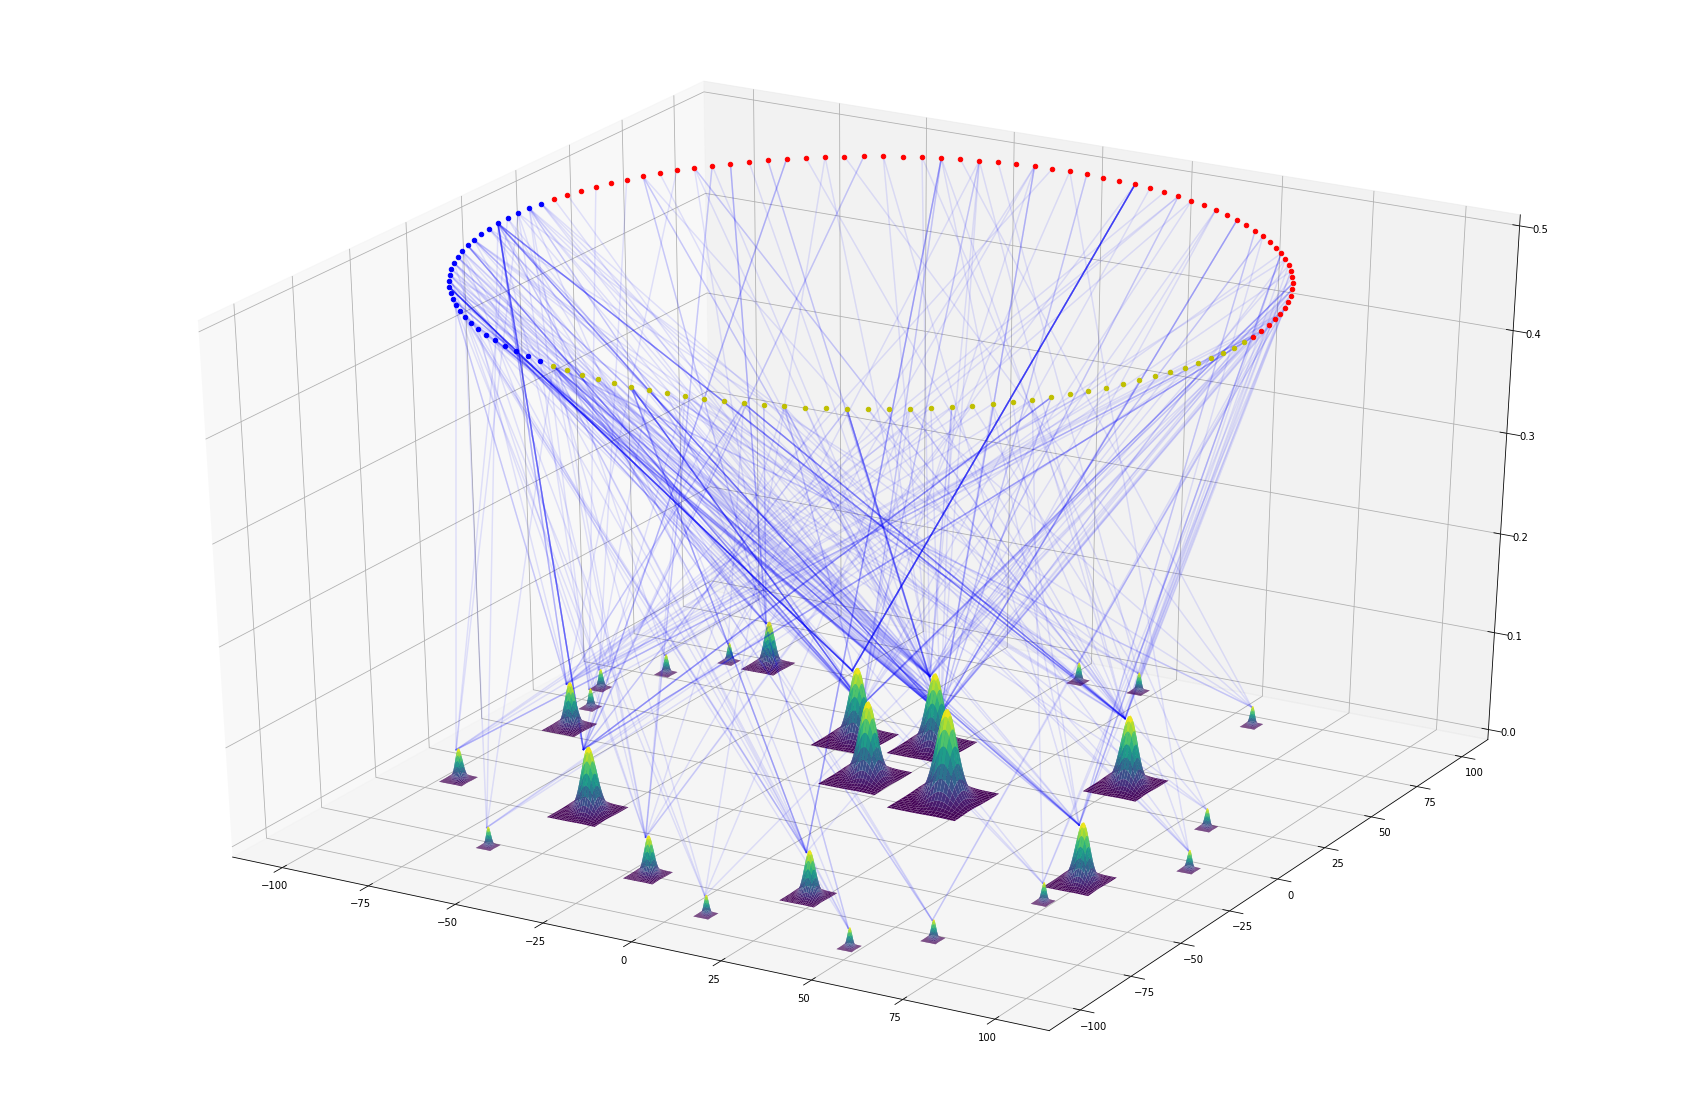

In [24]:
fig = plt.figure(figsize=[30,20])
ax = fig.gca(projection='3d')

for i in range(len(communities)):
    community = communities[i]
    center = xy_centers[i]
    
    nproteins = len(community)
    ngo = nproteins #TODO
    
    X,Y,Z = multivariate_gaussian_XYZ(N=60,
                                      center=center,
                                      xy_score=math.log(nproteins),
                                      z_score=math.log(nproteins)/5)
    
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(0,0.5)




# GO!!! GO GO GO YAY

increment= 360.0/131
degrees=[]
for i in range(1,132):
    degree=i*increment
    degrees.append(degree)
x_=[]
y_=[]

for i in degrees:
    x=100*math.cos(math.radians(i))
    y=100*math.sin(math.radians(i))
    x_.append(x)
    y_.append(y)
x=np.asarray(x_)
y=np.asarray(y_)
z=np.empty(131)
z.fill(0.5)

#ax.scatter(x, y, z)
    
GO_P=gene_data[['GO_P']]
GO_P=GO_P.dropna()
GO_P=GO_P.GO_P.unique()
GO_P=list(GO_P)

GO_C=gene_data[['GO_C']]
GO_C=GO_C.dropna()
GO_C=GO_C.GO_C.unique()
GO_C=list(GO_C)

GO_F=gene_data[['GO_F']]
GO_F=GO_F.dropna()
GO_F=GO_F.GO_F.unique()
GO_F=list(GO_F)

#x_y=zip(x_,y_)
x_y=[(x_0, y_0) for x_0, y_0 in zip(x_, y_)]
circle_tuples=[]
go_dict = {}

j = 0
for i in range(0, len(GO_P)):
    GO=GO_P[j]
    j += 1
    color='r'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    ax.scatter(x_y[i][0], x_y[i][1], 0.5, c=color)
    go_dict[GO]=coordinates

j = 0
for i in range(len(GO_P), len(GO_P)+len(GO_C)):
    GO=GO_C[j]
    j += 1
    color='b'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    ax.scatter(x_y[i][0], x_y[i][1], 0.5, c=color)
    go_dict[GO]=coordinates
 
j = 0
for i in range(len(GO_P)+len(GO_C), len(GO_P)+len(GO_C)+len(GO_F)):
    GO=GO_F[j]
    j += 1
    color='y'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    ax.scatter(x_y[i][0], x_y[i][1], 0.5, c=color)
    go_dict[GO]=coordinates
    
for x0_, x1_, y0_, y1_, z0_ in zip(x0, x1, y0, y1, z0):
    ax.plot3D([x0_, x1_], [y0_, y1_], [z0_, 0.5], 'b', alpha=0.1)

plt.show()

In [25]:
increment= 360.0/131
degrees=[]
for i in range(1,132):
    degree=i*increment
    degrees.append(degree)
x_=[]
y_=[]

for i in degrees:
    x=100*math.cos(math.radians(i))
    y=100*math.sin(math.radians(i))
    x_.append(x)
    y_.append(y)
x=np.asarray(x_)
y=np.asarray(y_)
z=np.empty(131)
z.fill(0.5)

#ax.scatter(x, y, z)
    
GO_P=gene_data[['GO_P']]
GO_P=GO_P.dropna()
GO_P=GO_P.GO_P.unique()
GO_P=list(GO_P)

GO_C=gene_data[['GO_C']]
GO_C=GO_C.dropna()
GO_C=GO_C.GO_C.unique()
GO_C=list(GO_C)

GO_F=gene_data[['GO_F']]
GO_F=GO_F.dropna()
GO_F=GO_F.GO_F.unique()
GO_F=list(GO_F)

#x_y=zip(x_,y_)
x_y=[(x_0, y_0) for x_0, y_0 in zip(x_, y_)]
circle_tuples=[]
go_dict = {}

j = 0
random.seed(1)
for i in range(0, len(GO_P)):
    t = random.randint(0, 25)
    s = [x_y[i][0]/math.fabs(x_y[i][0]), x_y[i][1]/math.fabs(x_y[i][1])]
    GO=GO_P[j]
    j += 1
    color='r'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    ax.scatter(x_y[i][0]-t*s[0], x_y[i][1]-t*s[1], 0.5, c=color)
    go_dict[GO]=(x_y[i][0]-t*s[0], x_y[i][1]-t*s[1])

j = 0
random.seed(2)
for i in range(len(GO_P), len(GO_P)+len(GO_C)):
    t = random.randint(0, 25)
    s = [x_y[i][0]/math.fabs(x_y[i][0]), x_y[i][1]/math.fabs(x_y[i][1])]
    GO=GO_C[j]
    j += 1
    color='b'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    ax.scatter(x_y[i][0]-t*s[0], x_y[i][1]-t*s[1], 0.5, c=color)
    go_dict[GO]=(x_y[i][0]-t*s[0], x_y[i][1]-t*s[1])
 
j = 0
random.seed(3)
for i in range(len(GO_P)+len(GO_C), len(GO_P)+len(GO_C)+len(GO_F)):
    t = random.randint(0, 25)
    s = [x_y[i][0]/math.fabs(x_y[i][0]), x_y[i][1]/math.fabs(x_y[i][1])]
    GO=GO_F[j]
    j += 1
    color='y'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    ax.scatter(x_y[i][0]-t*s[0], x_y[i][1]-t*s[1], 0.5, c=color)
    go_dict[GO]=(x_y[i][0]-t*s[0], x_y[i][1]-t*s[1])


In [26]:
x0 = []
x1 = []
y0 = []
y1 = []
z0 = []

for i in range(len(gene_data.index)):
    row = pd.Series(gene_data.iloc[i])
    if row['sym'] not in protein_to_centers:
        continue
    
    center = protein_to_centers[row['sym']]
    goc = row['GO_C']
    gof = row['GO_F']
    gop = row['GO_P']
    if goc in go_dict:
        x0.append(center[0])
        y0.append(center[1])
        z0.append(center[2])
        x1.append(go_dict[goc][0])
        y1.append(go_dict[goc][1])
        
    if gof in go_dict:
        x0.append(center[0])
        y0.append(center[1])
        z0.append(center[2])
        x1.append(go_dict[gof][0])
        y1.append(go_dict[gof][1])
        
    if gop in go_dict:
        x0.append(center[0])
        y0.append(center[1])
        z0.append(center[2])
        
        x1.append(go_dict[gop][0])
        y1.append(go_dict[gop][1])

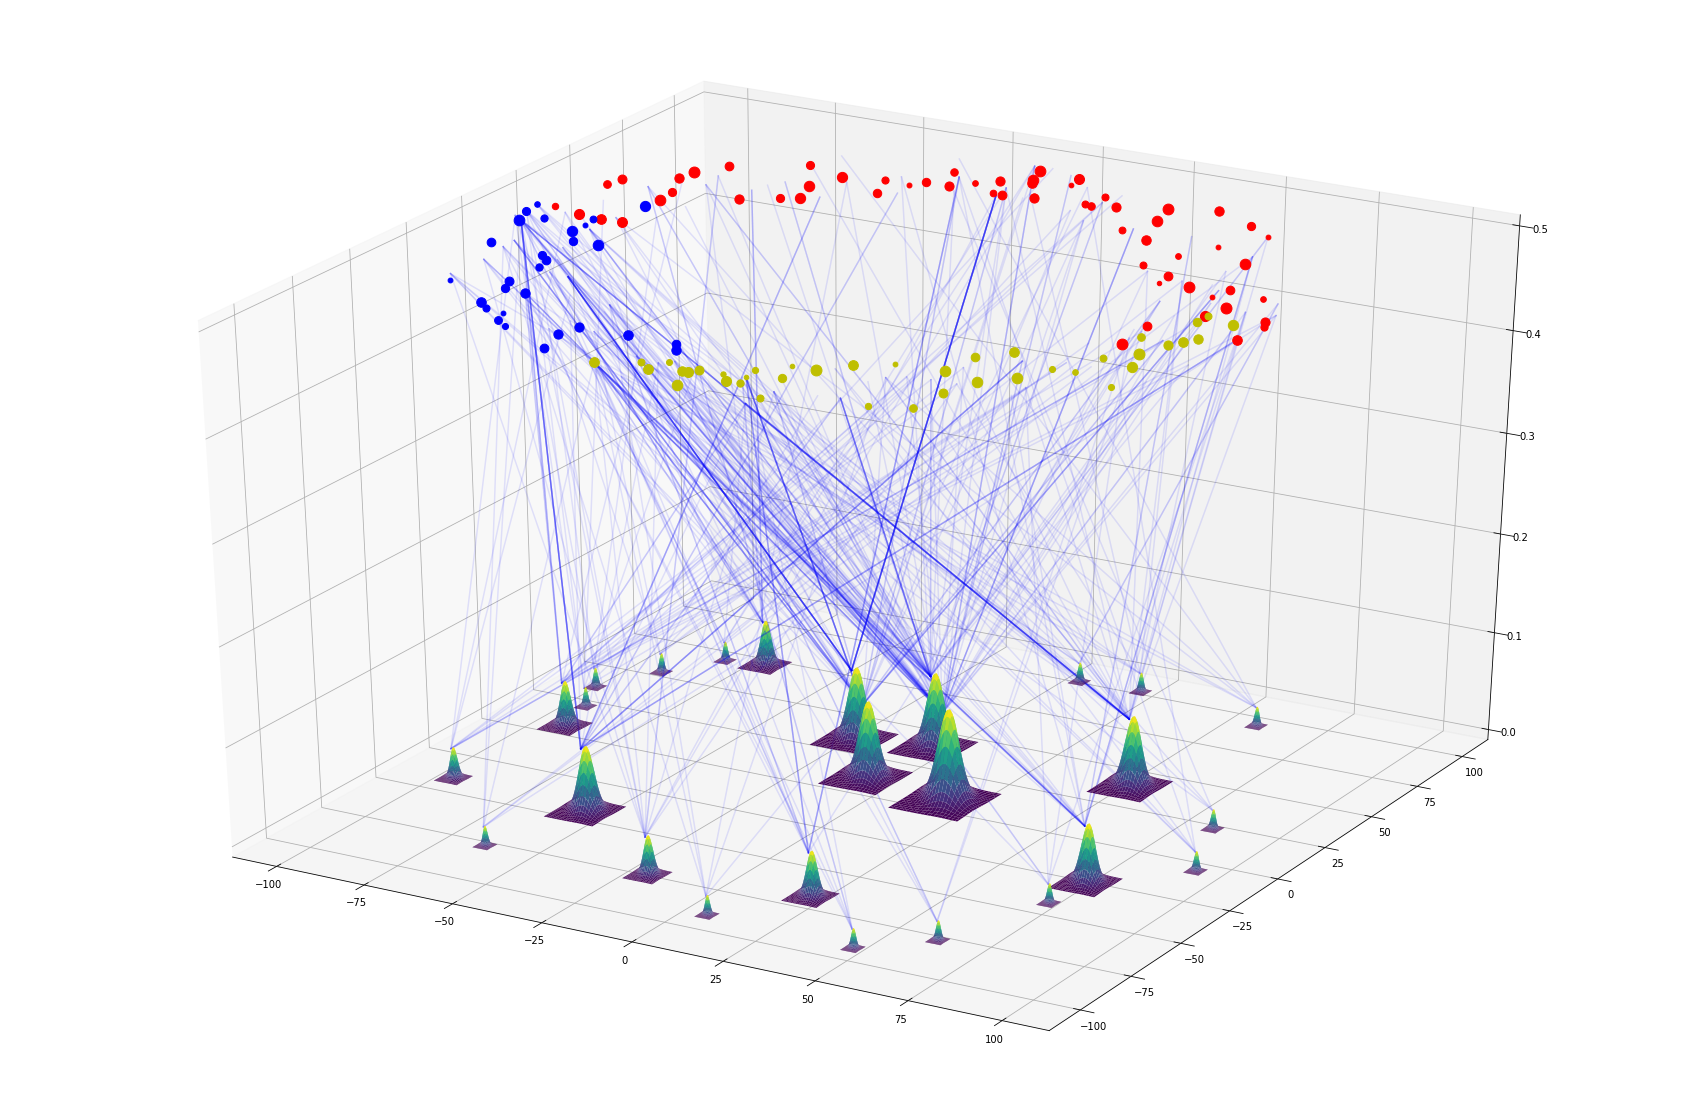

In [27]:
fig = plt.figure(figsize=[30,20])
ax = fig.gca(projection='3d')

for i in range(len(communities)):
    community = communities[i]
    center = xy_centers[i]
    
    nproteins = len(community)
    ngo = nproteins #TODO
    
    X,Y,Z = multivariate_gaussian_XYZ(N=60,
                                      center=center,
                                      xy_score=math.log(nproteins),
                                      z_score=math.log(nproteins)/5)
    
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(0,0.5)




# GO!!! GO GO GO YAY

increment= 360.0/131
degrees=[]
for i in range(1,132):
    degree=i*increment
    degrees.append(degree)
x_=[]
y_=[]

for i in degrees:
    x=100*math.cos(math.radians(i))
    y=100*math.sin(math.radians(i))
    x_.append(x)
    y_.append(y)
x=np.asarray(x_)
y=np.asarray(y_)
z=np.empty(131)
z.fill(0.5)

#ax.scatter(x, y, z)
    
GO_P=gene_data[['GO_P']]
GO_P=GO_P.dropna()
GO_P=GO_P.GO_P.unique()
GO_P=list(GO_P)

GO_C=gene_data[['GO_C']]
GO_C=GO_C.dropna()
GO_C=GO_C.GO_C.unique()
GO_C=list(GO_C)

GO_F=gene_data[['GO_F']]
GO_F=GO_F.dropna()
GO_F=GO_F.GO_F.unique()
GO_F=list(GO_F)

#x_y=zip(x_,y_)
x_y=[(x_0, y_0) for x_0, y_0 in zip(x_, y_)]
circle_tuples=[]
go_dict = {}

j = 0
random.seed(1)
for i in range(0, len(GO_P)):
    t = random.randint(0, 25)
    sz = random.randint(20, 120)
    s = [x_y[i][0]/math.fabs(x_y[i][0]), x_y[i][1]/math.fabs(x_y[i][1])]
    GO=GO_P[j]
    j += 1
    color='r'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    ax.scatter(x_y[i][0]-t*s[0], x_y[i][1]-t*s[1], 0.5, c=color, s=sz)

j = 0
random.seed(2)
for i in range(len(GO_P), len(GO_P)+len(GO_C)):
    t = random.randint(0, 25)
    sz = random.randint(20, 120)
    s = [x_y[i][0]/math.fabs(x_y[i][0]), x_y[i][1]/math.fabs(x_y[i][1])]
    GO=GO_C[j]
    j += 1
    color='b'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    ax.scatter(x_y[i][0]-t*s[0], x_y[i][1]-t*s[1], 0.5, c=color, s=sz)
 
j = 0
random.seed(3)
for i in range(len(GO_P)+len(GO_C), len(GO_P)+len(GO_C)+len(GO_F)):
    t = random.randint(0, 25)
    sz = random.randint(20, 120)
    s = [x_y[i][0]/math.fabs(x_y[i][0]), x_y[i][1]/math.fabs(x_y[i][1])]
    GO=GO_F[j]
    j += 1
    color='y'
    coordinates=x_y[i]
    circle_tuples.append((GO,color,coordinates))
    ax.scatter(x_y[i][0]-t*s[0], x_y[i][1]-t*s[1], 0.5, c=color, s=sz)
    
for x0_, x1_, y0_, y1_, z0_ in zip(x0, x1, y0, y1, z0):
    ax.plot3D([x0_, x1_], [y0_, y1_], [z0_, 0.5], 'b', alpha=0.1)

plt.show()